In [1]:
from sklearn.metrics import auc
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os, json

In [2]:
#preprocess

def sample_outliers(data, outlier):
    outlier_proportion = data[data.classALeRCE==outlier].shape[0] / data.shape[0]
    
    if outlier_proportion > 0.1:
        #Number of samples to remove.
        n_rm = round(data[data.classALeRCE==outlier].shape[0] - data.shape[0] * 0.1)

        df_subset = data[data.classALeRCE==outlier].sample(n_rm)
        data = data.drop(df_subset.index)
    else:
        #Number of samples to remove.
        n_rm  = round((data.shape[0] * 0.1 - data[data.classALeRCE==outlier].shape[0]) / 0.1)

        df_subset = data[data.classALeRCE!=outlier].sample(n_rm)
        data = data.drop(df_subset.index)
    return data


def get_data(hierClass, outlier):
    
    feature_list = pd.read_pickle('../data_raw/features_RF_model.pkl')
    train = pd.read_pickle('../data/train_data_filtered.pkl')
    test = pd.read_pickle('../data/test_data_filtered.pkl')
    
    train = train[train.hierClass==hierClass]    
    test = test[test.hierClass==hierClass]
    
    test = pd.concat([test, train[train.classALeRCE==outlier]], sort=False)
    test = sample_outliers(test, outlier)
    train = train[train.classALeRCE!=outlier]
    
    train = train[feature_list]
    train = train.fillna(-999)
    
    test_features = test[feature_list]
    test_features = test_features.fillna(-999)
    
    test_labels = np.where((test['classALeRCE']!= outlier), 0, test['classALeRCE']) #Inlier:0
    test_labels = np.where(test['classALeRCE']==outlier, 1, test_labels) #Type2:2
    test_labels = test_labels.reshape(-1,).astype('int8')
    return train, test_features, test_labels

In [3]:
#utils 
def save_metrics(metrics, root_dir, mode='val'):
    """save all the metrics."""
    mt_dir = os.path.join(root_dir, 'metrics_{}.json'.format(mode))
    with open(mt_dir, 'w') as mt:
        json.dump(metrics, mt)

def plot_histogram(in_scores, out_scores, directory):
    plt.hist(in_scores, color='k', alpha=0.3, density=True, label='Inlier')
    plt.hist(out_scores, color='b', alpha=0.3, density=True, label='Outlier')
    plt.title('Inliers vs Outliers (IForest)')
    plt.legend()
    plt.show()
    plt.savefig('{}/plots/histogram.png'.format(directory))
    plt.close()
    
def compute_metrics(scores, labels, plot_hist=True, directory=None):
    """
    Computing the Area under the curve ROC and PR.
    """
    in_scores = scores[labels==0]
    out_scores = scores[labels==1]

    auroc_out, aupr_out = compute_roc_pr(in_scores, out_scores)

    metrics = {'AU ROC': auroc_out,
               'AU PR': aupr_out,
               }
    if plot_hist:
        plot_histogram(in_scores, out_scores, directory)
    return metrics

def compute_roc_pr(inliers_scores, outlier_scores):
    auroc_score = auroc(inliers_scores, outlier_scores)
    aupr_score = aupr(inliers_scores, outlier_scores)
    return auroc_score, aupr_score

def auroc(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end- start)/100000

    tprs = []
    fprs = []
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(out_scores <= delta)) / np.float(len(out_scores))
        fpr = np.sum(np.sum(in_scores <= delta)) / np.float(len(in_scores))
        tprs.append(tpr)
        fprs.append(fpr)
    return auc(fprs, tprs)

def aupr(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end- start) / 100000
    
    precisions = []
    recalls = []
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(out_scores <= delta))
        fp = np.sum(np.sum(in_scores <= delta))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp / np.float(len(out_scores))
        precisions.append(precision)
        recalls.append(recall)
    return auc(recalls, precisions)

def print_metrics(metrics, directory):
    for metric, value in metrics.items():
        print("{}: {:.3f}".format(metric, value))
    print("##########################################")

In [4]:
def train(train_features, directory):
    clf = IsolationForest(n_estimators=100, max_samples=256, contamination=0.001).fit(train_features)
    pickle.dump(clf, open('{}/model.pkl'.format(directory), 'wb'))
    return clf

def test(model, test_features, test_labels, directory):
    scores = model.score_samples(test_features)
    metrics = compute_metrics(scores, test_labels, plot_hist=True, directory=directory)
    print_metrics(metrics, directory)
    save_metrics(metrics, directory, 'test')

## Transient Experiments

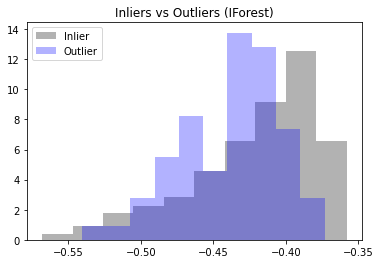

AU ROC: 0.658
AU PR: 0.137
##########################################


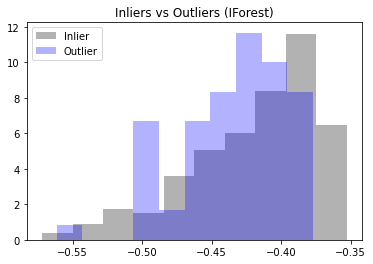

AU ROC: 0.628
AU PR: 0.129
##########################################


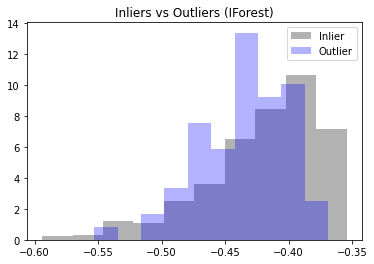

AU ROC: 0.639
AU PR: 0.132
##########################################


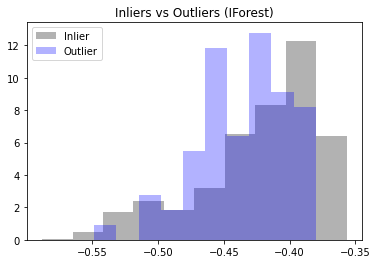

AU ROC: 0.637
AU PR: 0.130
##########################################


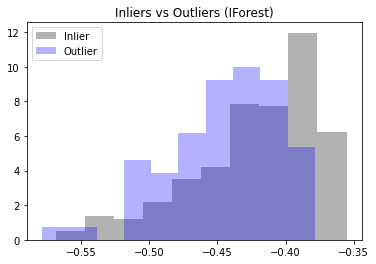

AU ROC: 0.664
AU PR: 0.144
##########################################


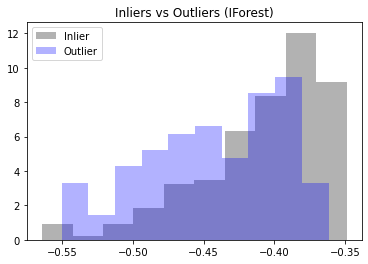

AU ROC: 0.711
AU PR: 0.335
##########################################


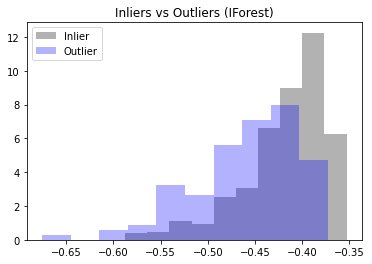

AU ROC: 0.737
AU PR: 0.388
##########################################


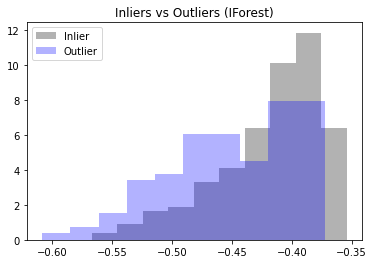

AU ROC: 0.684
AU PR: 0.347
##########################################


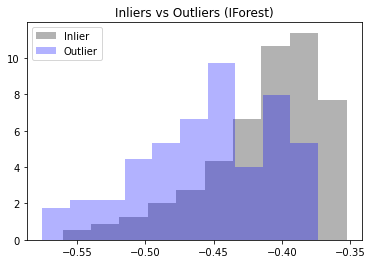

AU ROC: 0.738
AU PR: 0.386
##########################################


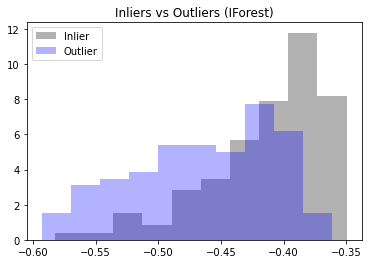

AU ROC: 0.766
AU PR: 0.442
##########################################


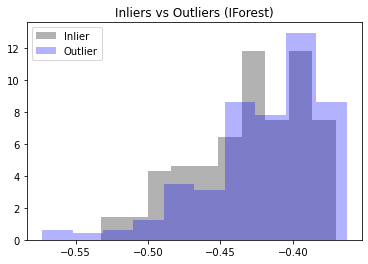

AU ROC: 0.421
AU PR: 0.526
##########################################


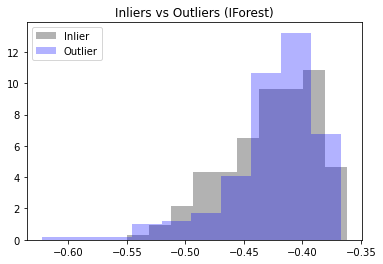

AU ROC: 0.472
AU PR: 0.563
##########################################


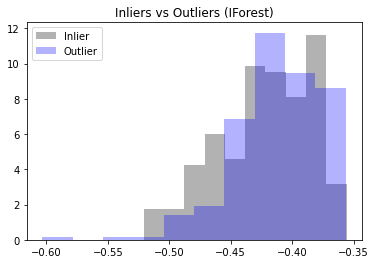

AU ROC: 0.421
AU PR: 0.512
##########################################


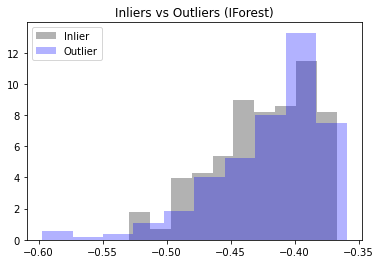

AU ROC: 0.442
AU PR: 0.548
##########################################


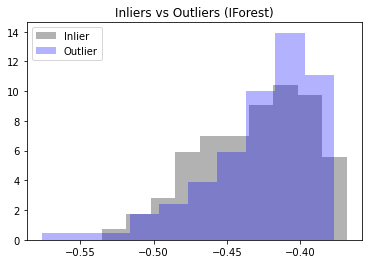

AU ROC: 0.439
AU PR: 0.543
##########################################


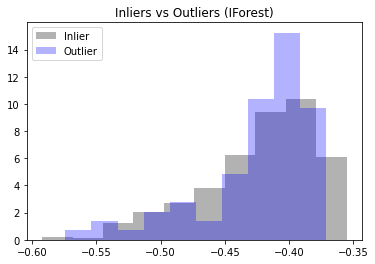

AU ROC: 0.508
AU PR: 0.116
##########################################


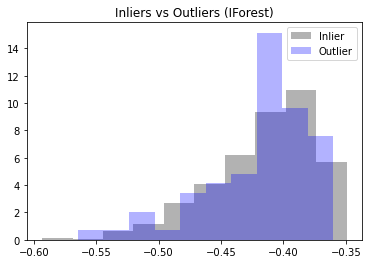

AU ROC: 0.536
AU PR: 0.126
##########################################


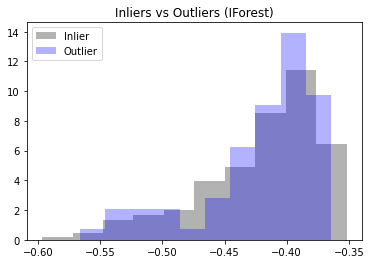

AU ROC: 0.525
AU PR: 0.117
##########################################


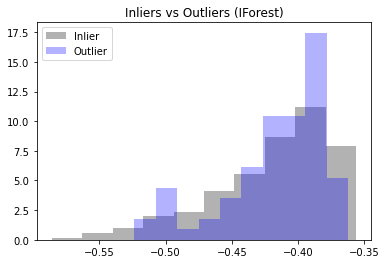

AU ROC: 0.486
AU PR: 0.103
##########################################


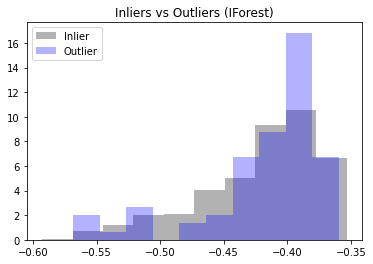

AU ROC: 0.485
AU PR: 0.115
##########################################


In [5]:
hierClass = 'Transient'
outliers = ['SLSN',
            'SNII',
            'SNIa',
            'SNIbc']

for outlier in outliers:
    for run in range(5):
        directory = './experiments/IForest_{}_{}_run{}'.format(hierClass, outlier, run)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plots_dir = '{}/plots'.format(directory)
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        train_features, test_features, test_labels = get_data(hierClass, outlier)
        model = train(train_features, directory)
        test(model, test_features, test_labels, directory)

## Stochastic Experiments

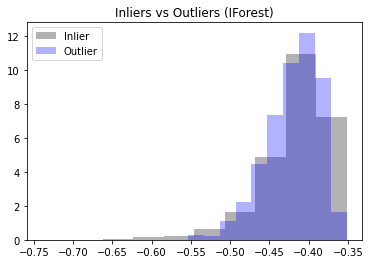

AU ROC: 0.548
AU PR: 0.147
##########################################


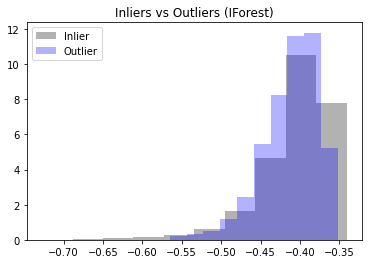

AU ROC: 0.574
AU PR: 0.153
##########################################


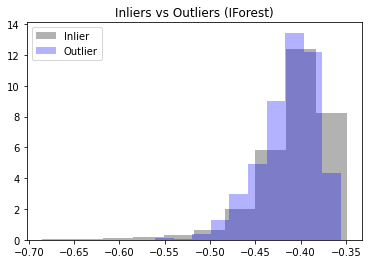

AU ROC: 0.576
AU PR: 0.157
##########################################


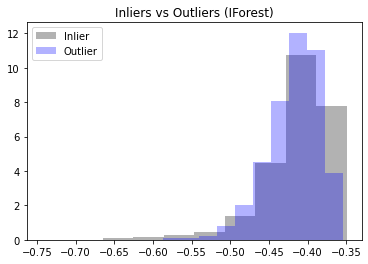

AU ROC: 0.561
AU PR: 0.151
##########################################


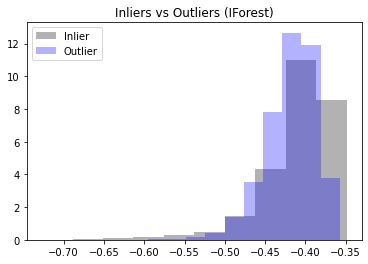

AU ROC: 0.611
AU PR: 0.166
##########################################


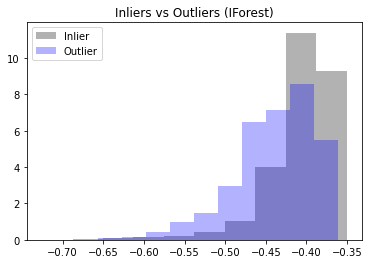

AU ROC: 0.709
AU PR: 0.214
##########################################


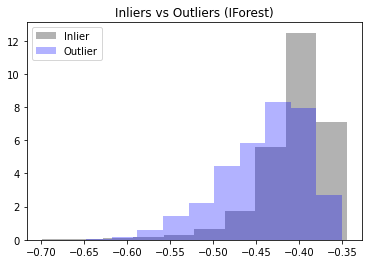

AU ROC: 0.712
AU PR: 0.216
##########################################


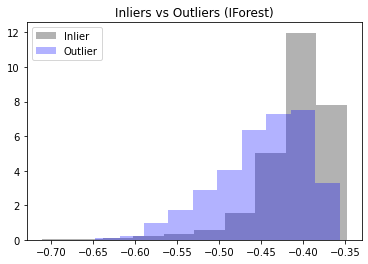

AU ROC: 0.730
AU PR: 0.234
##########################################


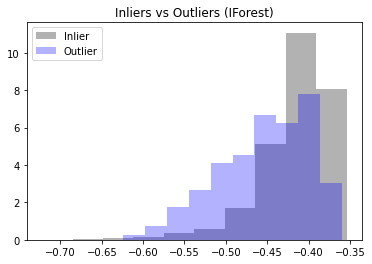

AU ROC: 0.710
AU PR: 0.228
##########################################


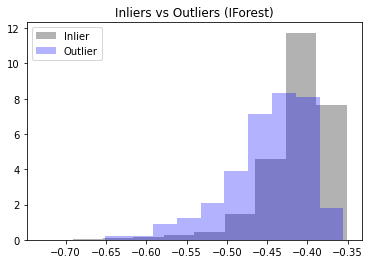

AU ROC: 0.722
AU PR: 0.216
##########################################


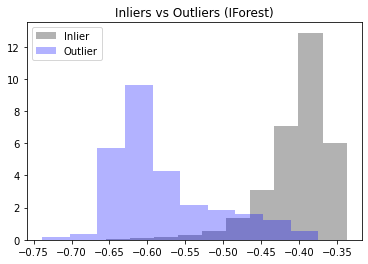

AU ROC: 0.973
AU PR: 0.879
##########################################


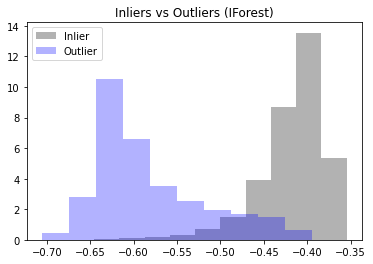

AU ROC: 0.971
AU PR: 0.873
##########################################


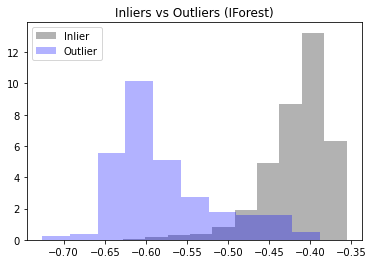

AU ROC: 0.971
AU PR: 0.879
##########################################


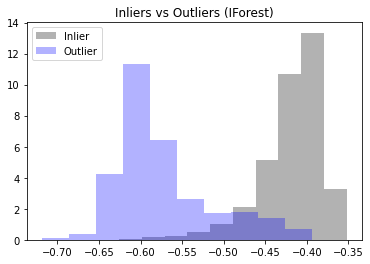

AU ROC: 0.970
AU PR: 0.872
##########################################


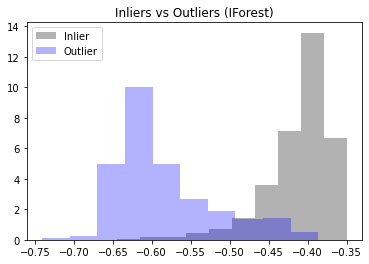

AU ROC: 0.973
AU PR: 0.872
##########################################


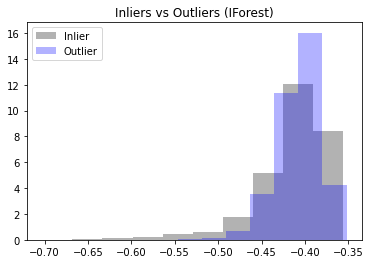

AU ROC: 0.473
AU PR: 0.631
##########################################


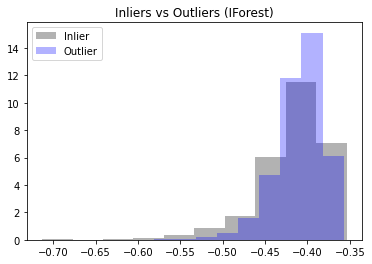

AU ROC: 0.457
AU PR: 0.627
##########################################


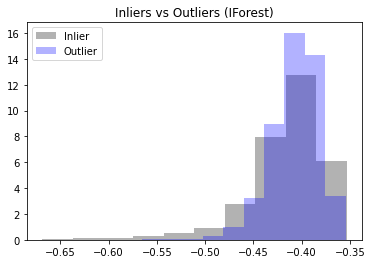

AU ROC: 0.445
AU PR: 0.618
##########################################


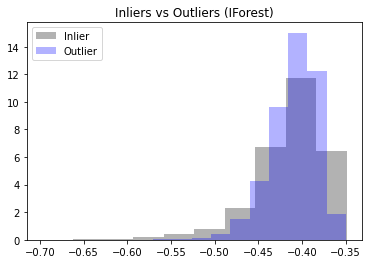

AU ROC: 0.497
AU PR: 0.647
##########################################


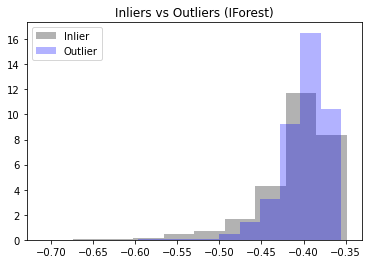

AU ROC: 0.439
AU PR: 0.617
##########################################


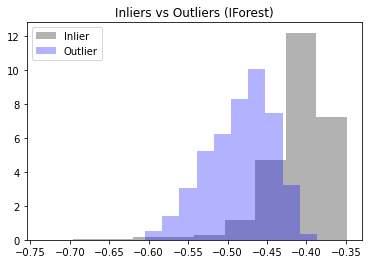

AU ROC: 0.919
AU PR: 0.478
##########################################


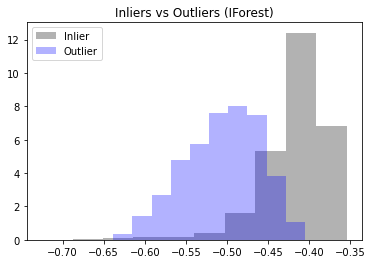

AU ROC: 0.936
AU PR: 0.539
##########################################


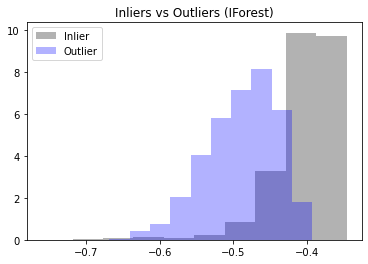

AU ROC: 0.926
AU PR: 0.502
##########################################


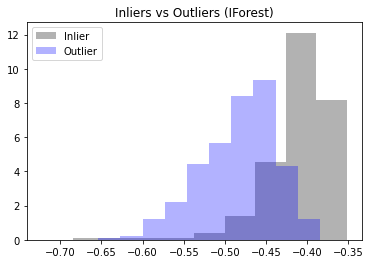

AU ROC: 0.904
AU PR: 0.447
##########################################


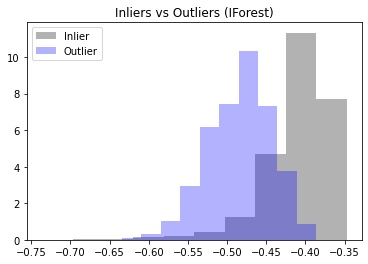

AU ROC: 0.915
AU PR: 0.462
##########################################


In [6]:
hierClass = 'Stochastic'
outliers = ['AGN',
            'Blazar',
            'CV/Nova',
            'QSO',
            'YSO']

for outlier in outliers:
    for run in range(5):
        directory = './experiments/IForest_{}_{}_run{}'.format(hierClass, outlier, run)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plots_dir = '{}/plots'.format(directory)
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        train_features, test_features, test_labels = get_data(hierClass, outlier)
        model = train(train_features, directory)
        test(model, test_features, test_labels, directory)

## Periodic Experiments

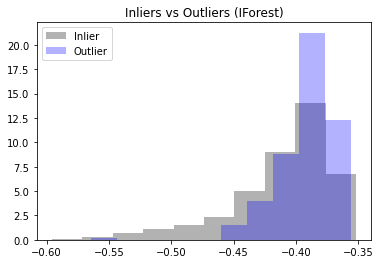

AU ROC: 0.362
AU PR: 0.072
##########################################


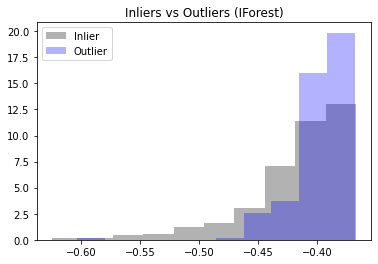

AU ROC: 0.364
AU PR: 0.072
##########################################


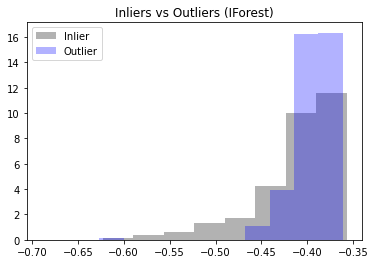

AU ROC: 0.393
AU PR: 0.075
##########################################


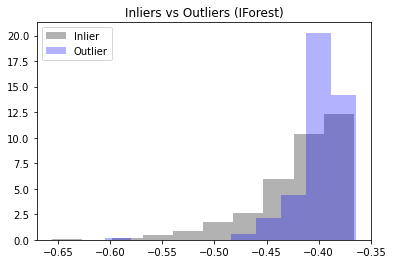

AU ROC: 0.358
AU PR: 0.071
##########################################


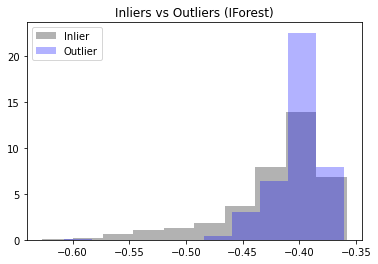

AU ROC: 0.380
AU PR: 0.074
##########################################


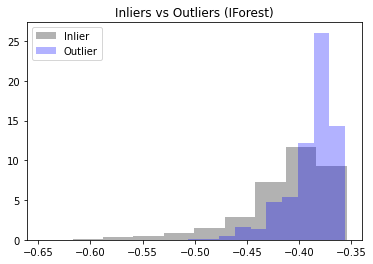

AU ROC: 0.286
AU PR: 0.064
##########################################


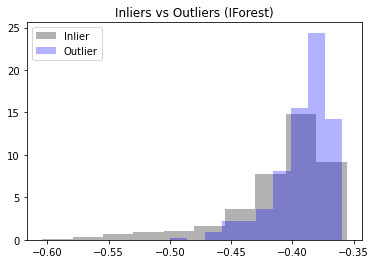

AU ROC: 0.354
AU PR: 0.071
##########################################


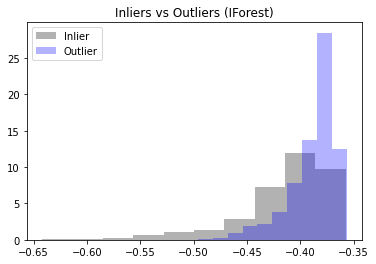

AU ROC: 0.279
AU PR: 0.063
##########################################


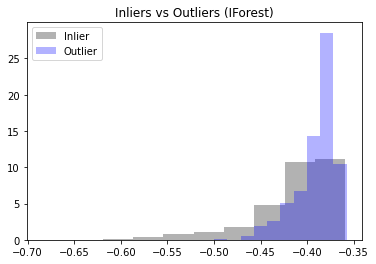

AU ROC: 0.294
AU PR: 0.065
##########################################


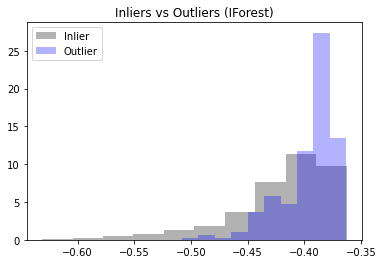

AU ROC: 0.306
AU PR: 0.066
##########################################


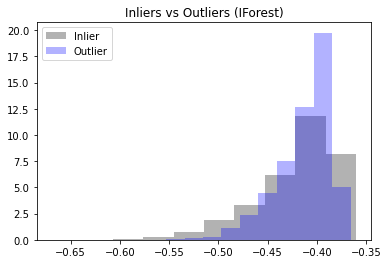

AU ROC: 0.464
AU PR: 0.230
##########################################


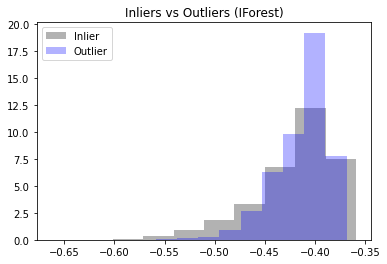

AU ROC: 0.477
AU PR: 0.234
##########################################


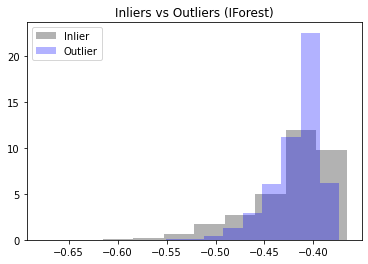

AU ROC: 0.500
AU PR: 0.241
##########################################


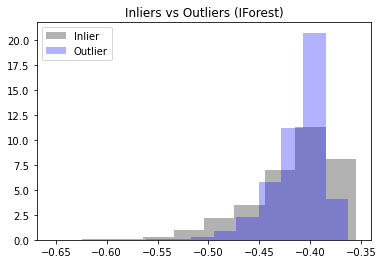

AU ROC: 0.505
AU PR: 0.241
##########################################


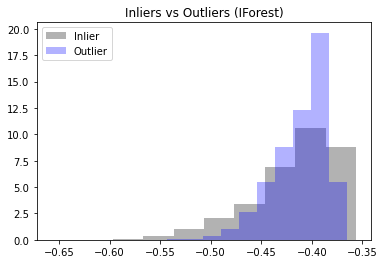

AU ROC: 0.486
AU PR: 0.236
##########################################


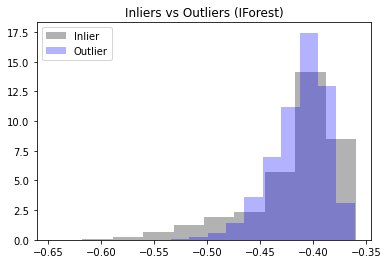

AU ROC: 0.525
AU PR: 0.264
##########################################


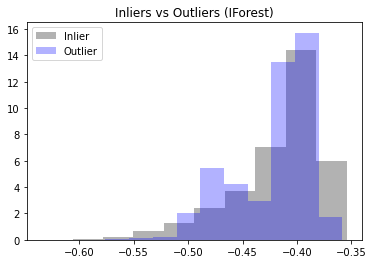

AU ROC: 0.563
AU PR: 0.294
##########################################


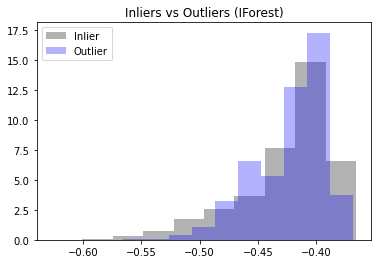

AU ROC: 0.510
AU PR: 0.262
##########################################


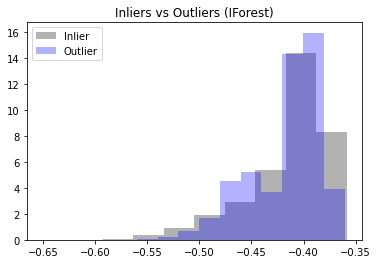

AU ROC: 0.534
AU PR: 0.279
##########################################


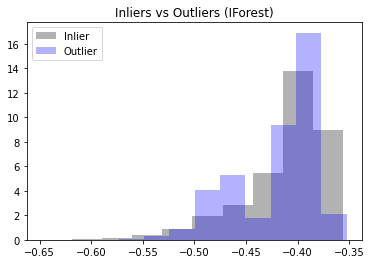

AU ROC: 0.562
AU PR: 0.306
##########################################


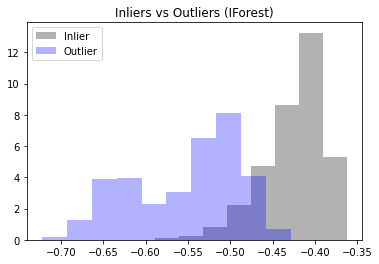

AU ROC: 0.971
AU PR: 0.905
##########################################


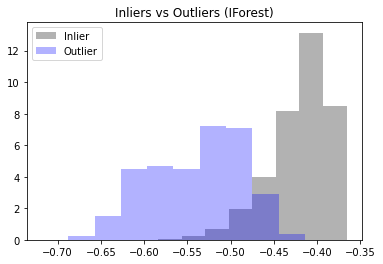

AU ROC: 0.974
AU PR: 0.916
##########################################


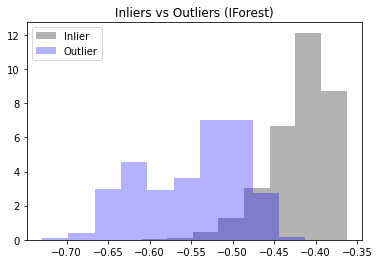

AU ROC: 0.973
AU PR: 0.909
##########################################


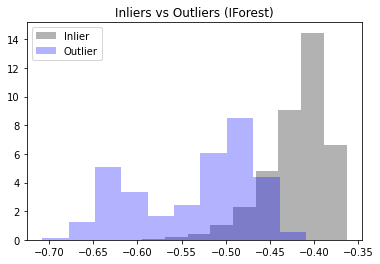

AU ROC: 0.959
AU PR: 0.871
##########################################


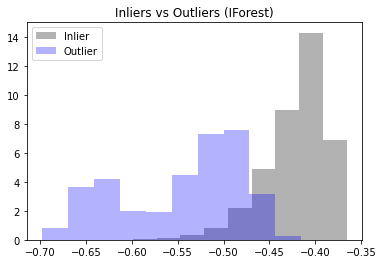

AU ROC: 0.971
AU PR: 0.905
##########################################


In [7]:
hierClass = 'Periodic'
outliers = ['CEP',
            'DSCT',
            'E',
            'RRL',
            'LPV']


for outlier in outliers:
    for run in range(5):
        directory = './experiments/IForest_{}_{}_run{}'.format(hierClass, outlier, run)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plots_dir = '{}/plots'.format(directory)
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        train_features, test_features, test_labels = get_data(hierClass, outlier)
        model = train(train_features, directory)
        test(model, test_features, test_labels, directory)